# Summarize the results of our experiment 2 pilots
For each pilot, this notebook will include:
    1) the experimental manipulations introduced
    2) the overall results (mean performance on each task)
    3) the key analysis (tilt x race) on each pilot

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime 
import matplotlib.pyplot as plt
import json
from scipy.stats import norm
import matplotlib.image as mpimg
import os, re
save_path = '/Users/chrisiyer/_Current/thesis_folder/face_experiment/results/data/exp2/'

In [2]:
###### import custom functions
import functions as fun
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

### load data

In [3]:
df = []
for file in os.listdir(save_path):
    if file.startswith('task'):
        df.append(pd.read_csv(save_path + file))
key = {
    0: 'pilot_prolific_exp2',
    1: 'pilot_proflici_exp2.2'
}

In [4]:
for i in range(len(df)):
    df[i]['tilted'] = (df[i].tilt_difference != 0) & (~df[i].tilt_difference.isna())
        
    df[i].loc[(df[i]['trial_type'] == 'retrieval') | (df[i]['trial_type'] == 'retrieval_practice'), 
   'response'] = pd.to_numeric(df[i].loc[(df[i]['trial_type'] == 'retrieval') | 
                                      (df[i]['trial_type'] == 'retrieval_practice'), 
                                      'response'])


# exclude if didn't finish the experiment
exclude = []
for i in range(len(df)):
    for j in df[i].subject_id.unique():
        curr = df[i][(df[i].subject_id == j) & (df[i].trial_type == 'summary')]
        if (len(curr) < 1):
            exclude.append(j)
    df[i] = df[i][ [k not in exclude for k in df[i].subject_id]]

print("IDENTITIES EXCLUDED:\n", exclude)

IDENTITIES EXCLUDED:
 []


### Helper functions

In [5]:
def rand_jitter(arr, stdev):
    return arr + np.random.randn(len(arr)) * stdev

def tilt_to_number(tilt):
    num = int(re.search(r'\d+', tilt).group())
    if tilt.endswith('L'):
        num = -num
    return num

def number_to_tilt(num):
    if num < 0:
        s = str(-num) + 'L'
    elif num > 0:
        s = str(num) + 'R'
    else: 
        s = '00C'
    return s
        
def get_tilt_change(o_tilt, n_tilt):
    difference = tilt_to_number(o_tilt) - tilt_to_number(n_tilt)
    change = number_to_tilt(difference)

    return {
        'change': change,
        'difference': difference
    }

In [6]:
def get_stats(data, only_correct_encoding = False, only_high_confidence = False):
    df_stat = pd.DataFrame(columns = ['experiment_id','iteration','race',
                                      
                                  'fil_acc', 'fil_rt', 'fil_acc_animals', 'fil_rt_animals', 
                                  'fil_acc_chairs', 'fil_rt_chairs', 'fil_acc_planes', 'fil_rt_planes',
                                      
                                  'ret_acc', 'ret_acc_w', 'ret_acc_b', 'ret_acc_delta',
                                  'ret_rt', 'ret_rt_w', 'ret_rt_b', 'ret_rt_delta',
                                  # breaking down by tilt
                                  'ret_acc_0', 'ret_acc_50', 'ret_acc_p50', 'ret_acc_n50', 
                                  'ret_acc_w_0', 'ret_acc_w_50', 'ret_acc_b_0', 'ret_acc_b_50',
                                  # retrieval distance/error instead of accuracy
                                  'ret_dist', 'ret_dist_0', 'ret_dist_50','ret_dist_w', 'ret_dist_b', 
                                  'ret_dist_w_0', 'ret_dist_w_50', 'ret_dist_b_0', 'ret_dist_b_50',
                                  'ret_dist_delta'
                                 ])
    
    for i_sub in data.experiment_id.unique():

        curr = []
        curr.extend([
            i_sub, # experiment_id
            data[data.experiment_id == i_sub].iteration.iloc[0], # iteration
        ]) 
        if len(data[(data.experiment_id == i_sub) & (data.trial_type == 'demographics')]) < 1:
            curr.append('') # race
        else: 
            curr.append(data[(data.experiment_id == i_sub) & (data.trial_type == 'demographics')].race.iloc[0]) # race

        enc = data[(data.experiment_id == i_sub) & (data.trial_type == 'encoding')]

        fil = data[(data.experiment_id == i_sub) & (data.trial_type == 'filler')]
        curr.extend([
            fil.correct.mean(),
            fil.rt.median(),
            fil[['choice_category','correct']].groupby('choice_category').correct.mean()['animals'],
            fil[['choice_category','rt']].groupby('choice_category').rt.median()['animals'],
            fil[['choice_category','correct']].groupby('choice_category').correct.mean()['chairs'],
            fil[['choice_category','rt']].groupby('choice_category').rt.median()['chairs'],
            fil[['choice_category','correct']].groupby('choice_category').correct.mean()['planes'],
            fil[['choice_category','rt']].groupby('choice_category').rt.median()['planes']
        ])
        
        ret = data[(data.experiment_id == i_sub) & ((data.trial_type == 'retrieval') | (data.trial_type == 'retrieval_practice'))]
        ret = fun.fix_practice_trials(ret)
        if (only_correct_encoding): ret = fun.filter_correct_encoding(ret,enc)
        if (only_high_confidence): ret = ret[(ret.response < 25) | (ret.response > 75)]
        
        curr.extend([          
            ret.correct.mean(),
            ret[['old_race','correct']].groupby('old_race').correct.mean()['white'],
            ret[['old_race','correct']].groupby('old_race').correct.mean()['black'],
            ret[['old_race','correct']].groupby('old_race').correct.mean()['white'] - 
                ret[['old_race','correct']].groupby('old_race').correct.mean()['black'],
            ret.rt.median(),
            ret[['old_race','rt']].groupby('old_race').rt.median()['white'],
            ret[['old_race','rt']].groupby('old_race').rt.median()['black'],
            ret[['old_race','rt']].groupby('old_race').rt.median()['white'] - 
                ret[['old_race','rt']].groupby('old_race').rt.median()['black']
        ])
        
        # accuracy by tilt
        td = abs(ret[ret.tilted].tilt_difference.iloc[0]) # tilt difference, 25 or 50
        
        curr.extend([
            ret[~ret.tilted].correct.mean(),
            ret[ret.tilted].correct.mean(),
            ret[ret.tilt_difference == td].correct.mean(),
            ret[ret.tilt_difference == -td].correct.mean(),
            
            ret[(~ret.tilted) & (ret.old_race == 'white')].correct.mean(),
            ret[(ret.tilted) & (ret.old_race == 'white')].correct.mean(),
            ret[(~ret.tilted) & (ret.old_race == 'black')].correct.mean(),
            ret[(ret.tilted) & (ret.old_race == 'black')].correct.mean(),
            
        ])
        
        # now add slider error/distance metrics 
        k = {1.0: 0, 2.0: 100}
        diffs = [abs(k[ret.iloc[i].correct_response] - ret.iloc[i].response) for i in range(len(ret))]
        ret['diffs'] = diffs
           
        curr.extend([
            ret.diffs.mean(),
            ret[~ret.tilted].diffs.mean(),
            ret[ret.tilted].diffs.mean(),
            ret[ret.old_race == 'white'].diffs.mean(),
            ret[ret.old_race == 'black'].diffs.mean(),
            ret[(~ret.tilted) & (ret.old_race == 'white')].diffs.mean(),
            ret[(ret.tilted) & (ret.old_race == 'white')].diffs.mean(),
            ret[(~ret.tilted) & (ret.old_race == 'black')].diffs.mean(),
            ret[(ret.tilted) & (ret.old_race == 'black')].diffs.mean(),
           ret[ret.old_race == 'white'].diffs.mean() - ret[ret.old_race == 'black'].diffs.mean(), # ret_dist_delta
        ])

        df_stat.loc[len(df_stat)] = curr
               
    return df_stat

### Plotting functions

In [7]:
# plot mean performance on each of the 3 tasks
def summary_plot(df_stat):
    lims = (0.4,1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,7))
    fig.suptitle('Task performance')
    
    ax1.boxplot(df_stat.fil_acc)
    ax1.set_xlabel('Filler')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_ylim(lims)

    ax2.boxplot(df_stat.ret_acc)
    ax2.set_xlabel('Retrieval')
    ax2.set_ylim(lims)

    plt.show()

In [8]:
#  hitrate on white vs. black faces

def hit_race_plot(df_stat):
    sz = (8,4)
    
    fig, ax = plt.subplots(1, 2, figsize=sz)

    ax[0].set_title('Retrieval accuracy white vs. black')
    ax[0].scatter(df_stat.ret_acc_white, df_stat.ret_acc_black)
    ax[0].set_xlabel('Retrieval accuracy on white faces (%)')
    ax[0].set_ylabel('Retrieval accuracy on black faces (%)')
    
    ax[1].set_title('Retrieval accuracy white vs. black')
    ax[1].scatter(df_stat.ret_d_white, df_stat.ret_d_black)
    ax[1].set_xlabel('Retrieval accuracy on white faces (%)')
    ax[1].set_ylabel('Retrieval accuracy on black faces (%)')

    plt.show()

#  hitrate on tilted vs. untilted items
def hit_tilt_plot(df_stat):
    
    sz = (8,4)
    
    fig, ax = plt.subplots(1, 2, figsize=sz)
    
    plt.suptitle('Hitrate tilted vs. untilted')
    
    plt.setp(ax, ylim=[0,1], xlabel='Tilt condition at retrieval', ylabel = 'Hit rate (%)')
    
    ax[0].set_title('(±1 SD)')
    ax[0].errorbar(x= [-50, 0, 50], 
             y = df_stat[['ret_acc_n50', 'ret_acc_0', 'ret_acc_p50']].mean(), 
             yerr = df_stat[['ret_acc_n50', 'ret_acc_0', 'ret_acc_p50']].std(),
            capsize =5, marker = 'o', mfc = 'red', mec='red', ms =8, ecolor='black', color='black')
    ax[0].scatter(x = rand_jitter(np.repeat(-50, len(df_stat)), 1),y = df_stat['ret_acc_n50'], color='gray',alpha=0.2)
    ax[0].scatter(x = rand_jitter(np.repeat(0, len(df_stat)), 1),y = df_stat['ret_acc_0'], color='gray',alpha=0.2)
    ax[0].scatter(x = rand_jitter(np.repeat(50, len(df_stat)), 1),y = df_stat['ret_acc_p50'], color='gray',alpha=0.2)
    ax[0].set_xticks([-50,0,50])
#     ax[0].set_xlabel('Tilt condition at retrieval')
#     ax[0].set_ylabel('Hit rate (%)')

    
    ax[1].set_title('Collapsed symmetrically (±1 SD)')
    ax[1].errorbar(x= [0, 50], 
             y = df_stat[['ret_acc_0', 'ret_acc_50']].mean(), 
             yerr = df_stat[['ret_acc_0', 'ret_acc_50']].std(),
            capsize =5, marker = 'o', mfc = 'red', mec='red', ms =8, ecolor='black', color='black')
    ax[1].scatter(x = rand_jitter(np.repeat(0, len(df_stat)), 1),y = df_stat['ret_acc_0'], color='gray',alpha=0.2)
    ax[1].scatter(x = rand_jitter(np.repeat(50, len(df_stat)), 1),y = df_stat['ret_acc_50'], color='gray',alpha=0.2)
    
    ax[1].set_xticks([0,50])
    
    plt.show()
# plt.errorbar(x, y, yerr, marker='s', mfc='red',mec='green', ms=20, mew=4)


# above but interacting with race
def hit_tilt_race_plot(df_stat):
    
    c = ['blue', 'green']
    buffer = 2
    al = 0.1

    plt.figure(figsize=(4, 4), dpi=80)
    plt.errorbar(x= np.array([0, 50])-buffer, 
             y = df_stat[['ret_acc_w_0', 'ret_acc_w_50']].mean(), 
             yerr = df_stat[['ret_acc_w_0', 'ret_acc_w_50']].std(),
            capsize =5, marker = 'o', mfc = c[0], mec=c[0], ms =8, ecolor=c[0], color=c[0], label = 'white')

    plt.errorbar(x= np.array([0, 50])+buffer, 
             y = df_stat[['ret_acc_b_0', 'ret_acc_b_50']].mean(), 
             yerr = df_stat[['ret_acc_b_0', 'ret_acc_b_50']].std(),
            capsize =5, marker = 'o', mfc = c[1], mec=c[1], ms =8, ecolor=c[1], color=c[1], label = 'black')

    plt.scatter(x = rand_jitter(np.repeat(0-buffer, len(df_stat)), 1),y = df_stat['ret_acc_w_0'], color=c[0], alpha=al)
    plt.scatter(x = rand_jitter(np.repeat(0+buffer, len(df_stat)), 1),y = df_stat['ret_acc_0'], color=c[1], alpha=al)
    plt.scatter(x = rand_jitter(np.repeat(50-buffer, len(df_stat)), 1),y = df_stat['ret_acc_w_50'], color=c[0], alpha=al)
    plt.scatter(x = rand_jitter(np.repeat(50+buffer, len(df_stat)), 1),y = df_stat['ret_acc_50'], color=c[1], alpha=al)

    plt.xlabel('Tilt condition at retrieval (absolute value)')
    plt.xticks([0,50]); plt.xlim(-25,75)
    plt.ylabel('Hit rate (%)')
    plt.ylim(0,1)
    plt.suptitle('Hit rate on tilted and untilted old items, by race')
    plt.title('n=30, ±1 SD', fontsize=10)
    plt.legend()
    plt.show()

## 1. Pilot_prolific_exp2 (n = 10). 

25˚ tilt change, 40 trials, 3s/encoding trial, within-group AFC pairs.

In [14]:
stats = get_stats(df[0])

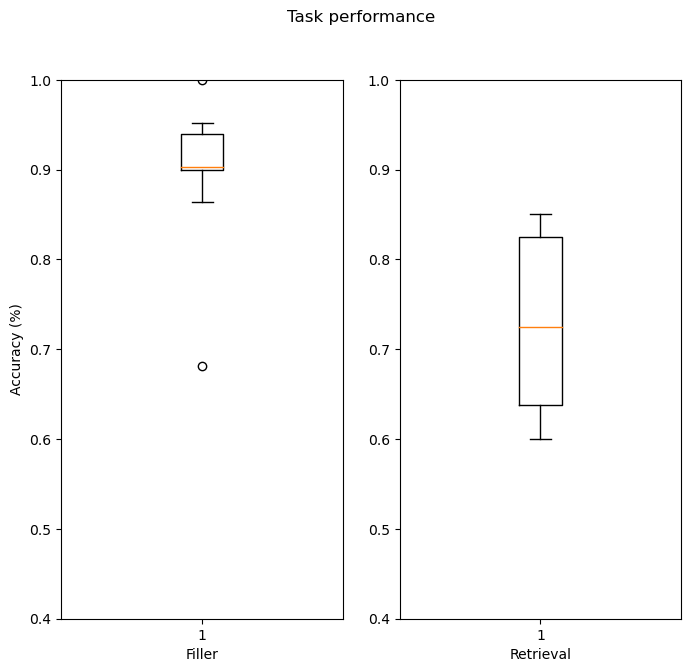

/Users/chrisiyer/miniconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/chrisiyer/miniconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


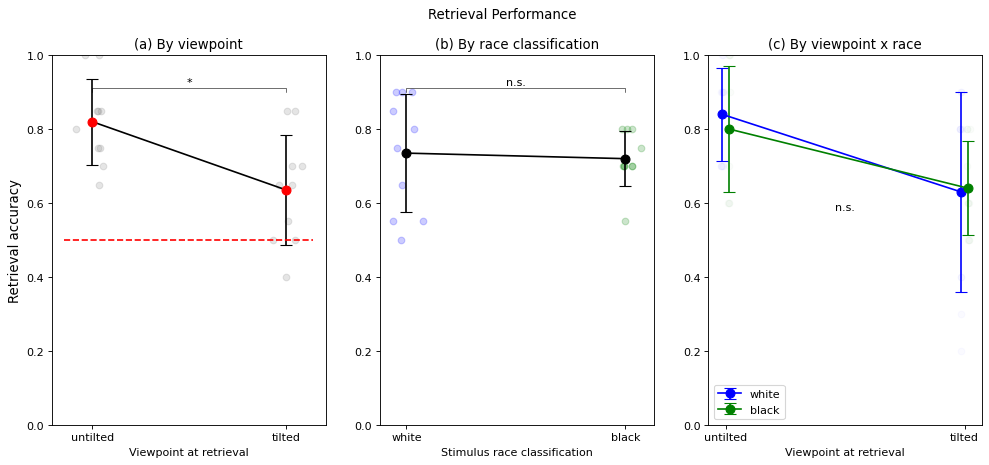

In [15]:
summary_plot(stats)
fun.retrieval_plots(stats)

# 2. Pilot_prolific_exp2.2 

Same but stims in color

In [11]:
stats = get_stats(df[1])

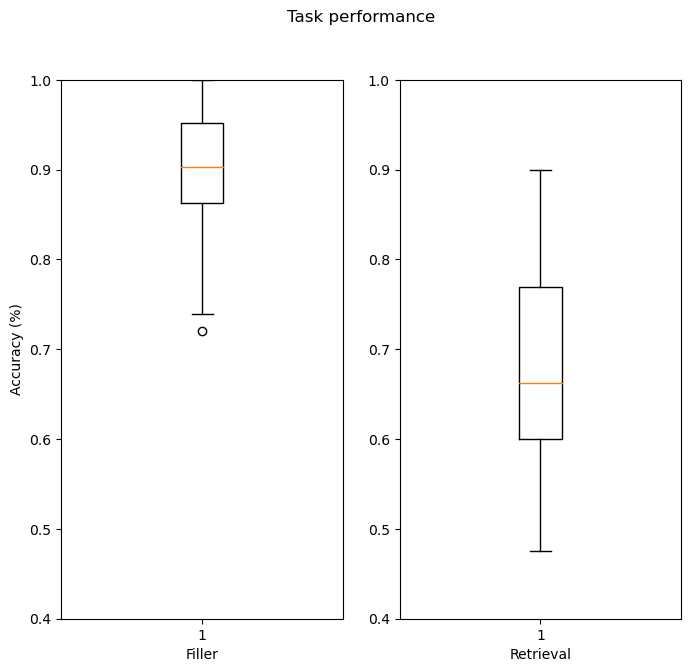

/Users/chrisiyer/miniconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/chrisiyer/miniconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


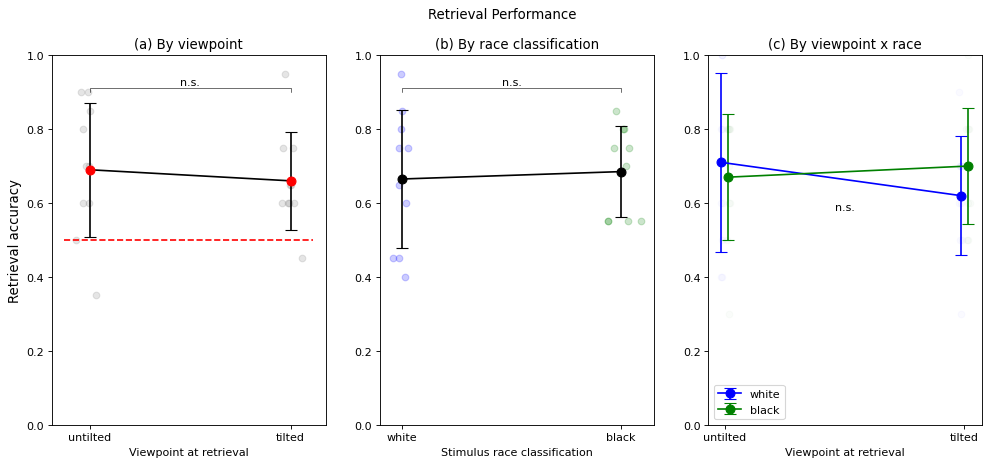

In [12]:
summary_plot(stats)
fun.retrieval_plots(stats)

## Combining these two pilots' data

In [23]:
df[0:1]

AttributeError: 'list' object has no attribute 'dim'

In [ ]:
stats = get_stats(pd.concat(df[1])
summary_plot(stats)
fun.retrieval_plots(stats)